# Imports and Constants

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os


FILENAME_PROCESSED = "processed_data.csv"
DF = pd.read_csv(FILENAME_PROCESSED)

# Plot functions

In [86]:
def plot_bar_from_column(df, column_name, title, xlabel, ylabel):
    # Count the occurrences of each role

    if column_name == 'bva_familiarity':
        order = ["Not at all familiar", "Somewhat familiar", "Quite familiar", "Expert"]
        role_counts = df[column_name].value_counts().reindex(order, fill_value=0)
    else:
        role_counts = df[column_name].value_counts()

    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(9, 6))

    # Bar colors and transparency
    bars = ax.bar(role_counts.index, role_counts.values, color='#4c72b0', alpha=0.85)

    # Add count labels above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(int(height)),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Titles and labels
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)

    # Rotate x-axis labels for readability
    plt.xticks(rotation=30, ha='right', fontsize=11)
    plt.yticks(fontsize=11)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
    
def plot_histogram(df, column_name, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(9, 6))
    # Compute histogram data and get bin edges
    counts, bins, patches = ax.hist(
        df[column_name],
        bins=range(min(df[column_name]), max(df[column_name]) + 2),
        color='#4c72b0',
        alpha=0.85,
    )
    # Titles and labels
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)

    # Calculate bin centers for xticks
    bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]
    ax.set_xticks(bin_centers)
    ax.set_xticklabels([str(int(center)) for center in bin_centers], fontsize=11)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
    
def plot_domain_counts(df):
    # Mapping of column names to display names
    domain_labels = {
        'domain_web': 'Web / Cloud services',
        'domain_mobile': 'Mobile Applications',
        'domain_embedded': 'Embedded / IoT',
        'domain_enterprise': 'Enterprise / Backend',
        'domain_ai': 'AI / ML',
        'domain_games': 'Games'
    }

    # Count the number of 1.0s in each domain column
    counts = {label: int(df[col].sum()) for col, label in domain_labels.items() if col in df.columns}

    # Handle 'domain_other' based on text_domain_other content
    if 'domain_other' in df.columns and 'text_domain_other' in df.columns:
        # Get non-empty entries where domain_other == 1.0
        other_entries = df.loc[df['domain_other'] == 1.0, 'text_domain_other'].dropna().astype(str).str.strip()
        # Count how many filled responses
        other_count = other_entries.shape[0]
        # Join unique values for display (optional)
        other_label = 'Other: ' + ', '.join(other_entries.unique()) if not other_entries.empty else 'Other'
        counts[other_label] = other_count
        
    # Make sure the color list matches the number of bars
    colors = [
    '#A1C9F4',  # light blue
    '#8DE5A1',  # mint green
    '#FF9F9B',  # coral pink
    '#D0BBFF',  # light lavender
    '#FFBE7D',  # peach
    '#4c72b0',  # dark blue
    '#C7CEEA',  # pale periwinkle
    ]
    color_list = colors[:len(counts)] if len(counts) <= len(colors) else [colors[i % len(colors)] for i in range(len(counts))]


    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(counts.keys(), counts.values(), color=color_list)

    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.title('Distribution of Domains', fontsize=14, fontweight='bold')
    plt.xlabel('Domain', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=30, ha='right', fontsize=11)
    plt.yticks(fontsize=11)

    plt.tight_layout()
    plt.show()
    
def plot_descriptive_comparison(desc_df, sut, category):
    # Filter only mean and std for plotting
    stats_to_plot = desc_df[['mean', 'std']]

    # Plot
    stats_to_plot.plot(kind='bar', figsize=(10, 6), colormap='Pastel1')
    
    plt.title(f'Mean and Standard Deviation per {sut} example (and all combined)', fontsize=14, fontweight='bold')
    plt.xlabel('Email_n_clear Columns', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Statistic', fontsize=10)
    plt.tight_layout()
    plt.show()


def plot_box_per_sut(df, sut):
    """
    sut: email, bytecnt, date, bmi
    Plots 4 subplots (boxplots) for the 4 categories and saves stats as CSVs.
    """

    # Apply appealing plot style
    sns.set_theme(style="whitegrid", font_scale=1.2)  # Increases global font size

    categories = ['clarity', 'completeness', 'correctness', 'usefulness']
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, category in enumerate(categories):
        desc_stats, cols = calculate_descriptives(df, sut, category)

        # Save stats to CSV
        csv_filename = f"{sut}_{category}_stats.csv"
        desc_stats.to_csv(f'stats_per_category/{csv_filename}')

        # Prepare data for plotting
        melted_df = df[cols].melt(var_name=sut.capitalize(), value_name=category.capitalize())
        combined = pd.DataFrame({
            sut.capitalize(): ['combined'] * df[cols].stack().shape[0],
            category.capitalize(): df[cols].stack().values
        })
        plot_df = pd.concat([melted_df, combined], ignore_index=True)

        # Plot
        ax = axes[i // 2, i % 2]
        sns.boxplot(
            data=plot_df,
            x=f"{sut.capitalize()}",
            y=f"{category.capitalize()}",
            palette='bright',
            ax=ax,
        )
        
        for patch in ax.patches:
            patch.set_alpha(0.5)  # Adjust to desired transparency level

        ax.set_title(f'{category.capitalize()}', fontsize=22, fontweight='bold')
        ax.set_xlabel('Example', fontsize=20)
        ax.set_ylabel('Score', fontsize=20)
        ax.set_yticks([1, 2, 3, 4, 5])
        ax.tick_params(axis='x', rotation=30, labelsize=18)
        ax.tick_params(axis='y', labelsize=18)

        # Custom x-tick labels
        xticks = plot_df[f"{sut.capitalize()}"].unique()
        ax.set_xticklabels(['BC1', 'BC2', 'BC3', 'BC4', 'BC5', 'All BCs'])

    plt.tight_layout()
    plt.savefig(f"plots/{sut}_boxplots.pdf", format="pdf", bbox_inches="tight")
    plt.show()


def plot_box_and_table_per_category(df, category):
    """
    category: clarity, completeness, correctness, usefulness
    This function plots and calculates stats per SUT for the selected category.
    """

    # Identify SUTs based on column prefixes (assumes consistent naming like email_1_clarity, etc.)
    suts = ['email', 'bytecnt', 'date', 'bmi']
    data = []
    stats_dict = {}

    for sut in suts:
        # Get all columns for this SUT and category
        cols = [col for col in df.columns if col.startswith(f"{sut}_") and col.endswith(f"_{category}")]
        if not cols:
            continue  # Skip if this SUT has no relevant columns

        # Combine all into a long format
        stacked = df[cols].stack().reset_index(drop=True)
        data.extend([(sut.upper(), val) for val in stacked.dropna()])

        # Descriptive stats for this SUT
        sut_desc = stacked.describe()[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        stats_dict[sut.upper()] = np.round(sut_desc.values, 2)

    # Create DataFrame for plotting
    plot_df = pd.DataFrame(data, columns=['SUT', category.capitalize()])

    # Create DataFrame for stats table
    stats_df = pd.DataFrame.from_dict(stats_dict, orient='index', 
                                      columns=['mean', 'std', 'min', '25%', '50%', '75%', 'max'])

    # Plot layout: one column, two rows
    fig = plt.figure(constrained_layout=True, figsize=(10, 10))
    gs = GridSpec(2, 1, height_ratios=[3, 1], figure=fig)

    # Boxplot
    ax1 = fig.add_subplot(gs[0])
    sns.boxplot(data=plot_df, x='SUT', y=category.capitalize(), palette='pastel', ax=ax1)
    ax1.set_title(f'{category.capitalize()} Score Distribution per SUT', fontsize=14, fontweight='bold')
    ax1.set_xlabel('SUT')
    ax1.set_ylabel(f'{category.capitalize()}')
    ax1.set_yticks([1, 2, 3, 4, 5])
    ax1.tick_params(axis='x', rotation=30)

    # Table
    ax2 = fig.add_subplot(gs[1])
    ax2.axis('off')
    table = ax2.table(cellText=stats_df.values,
                      rowLabels=stats_df.index,
                      colLabels=stats_df.columns,
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax2.set_title('Descriptive Statistics by SUT', fontsize=12, fontweight='bold')

    plt.show()

# Calculation functions

In [59]:
# Function to calculate descriptive stats
def calculate_descriptives(df, sut, category):
    cols = [col for col in df.columns if col.startswith(sut) and col.endswith(category)]
    desc_per_column = df[cols].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    combined = pd.concat([df[col].dropna() for col in cols], ignore_index=True)
    combined_desc = combined.describe()[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    desc_per_column.loc['combined'] = combined_desc
    return desc_per_column, cols

# Background of Participants

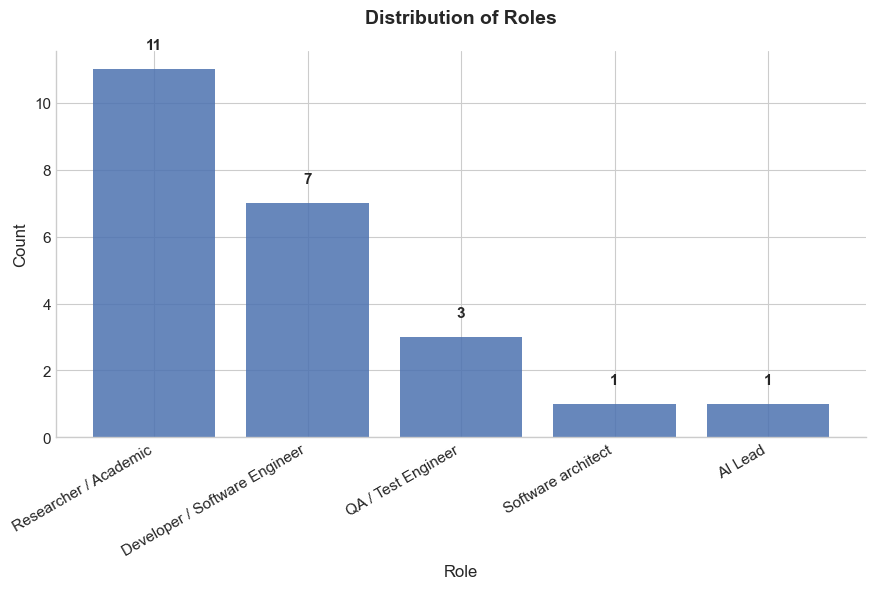

In [60]:
plot_bar_from_column(DF, 'role', 'Distribution of Roles', 'Role', 'Count')

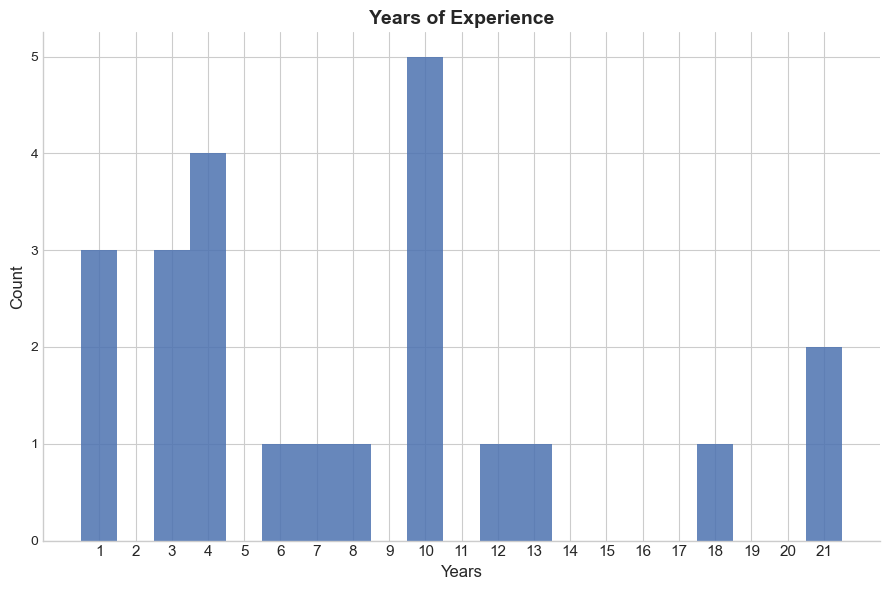

In [61]:
plot_histogram(DF, 'years_experience', 'Years of Experience', 'Years', 'Count')

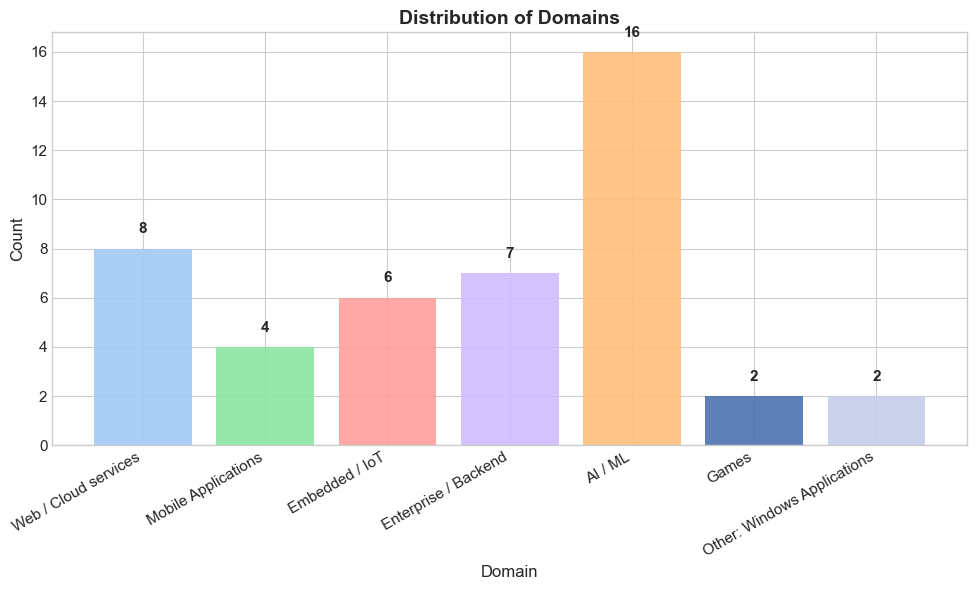

In [62]:
plot_domain_counts(DF)

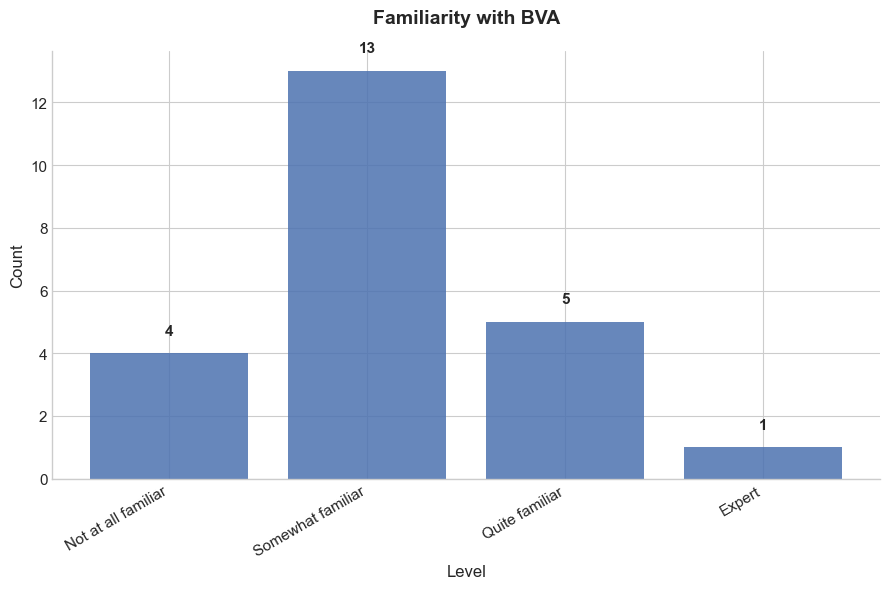

In [63]:
plot_bar_from_column(DF, 'bva_familiarity', 'Familiarity with BVA', 'Level', 'Count')

# Descriptive Statistics: Across all SUTs

## *How does --Clarity-- vary across all SUTs?*

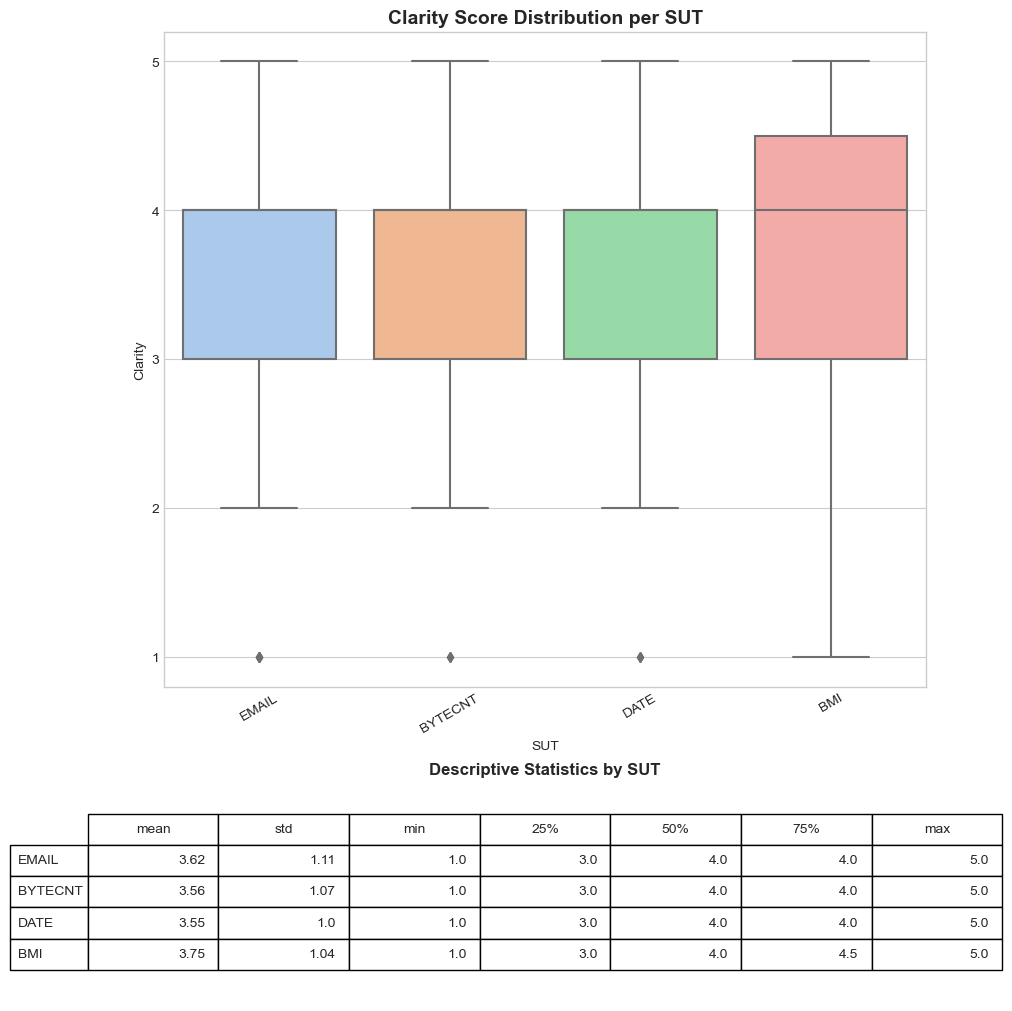

In [64]:
plot_box_and_table_per_category(DF, "clarity")

## *How does --Correctness-- vary across all SUTs?*

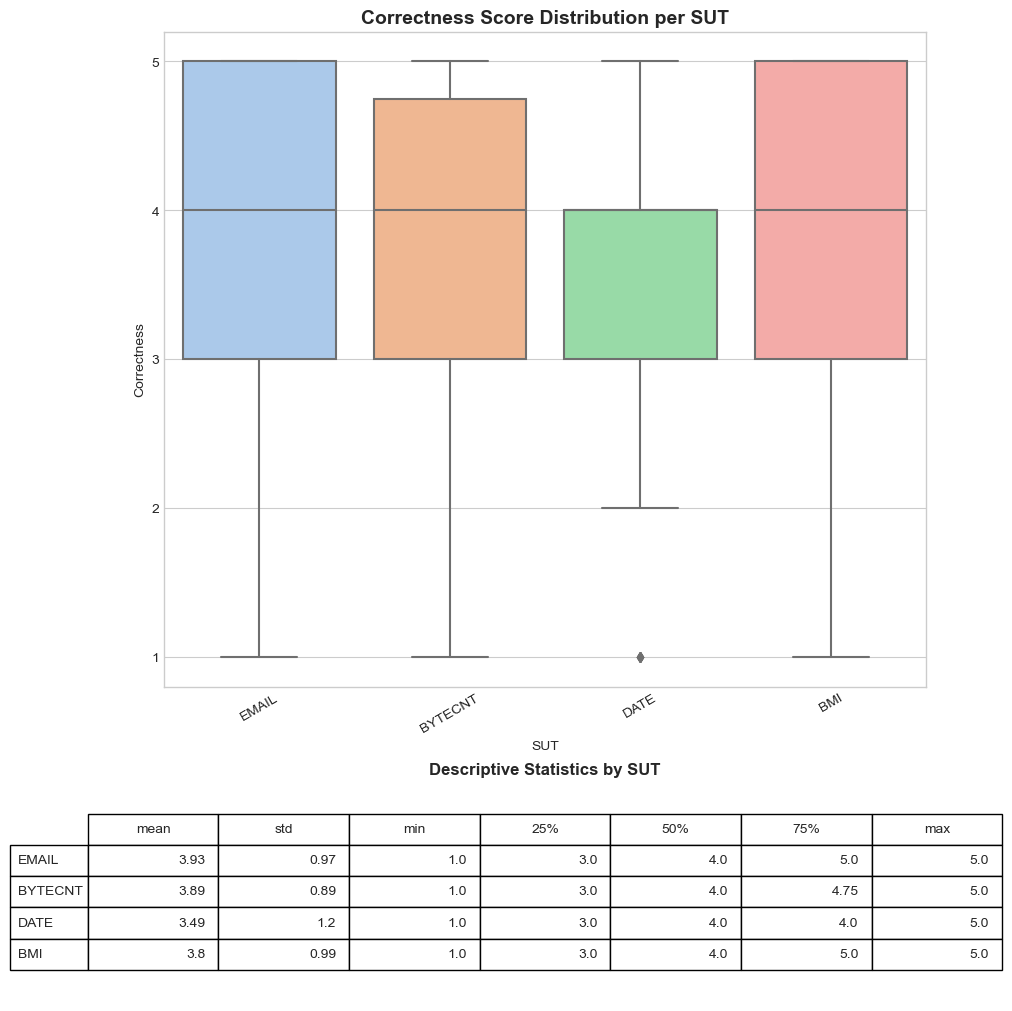

In [65]:
plot_box_and_table_per_category(DF, "correctness")

## *How does --Completeness-- vary across all SUTs?*

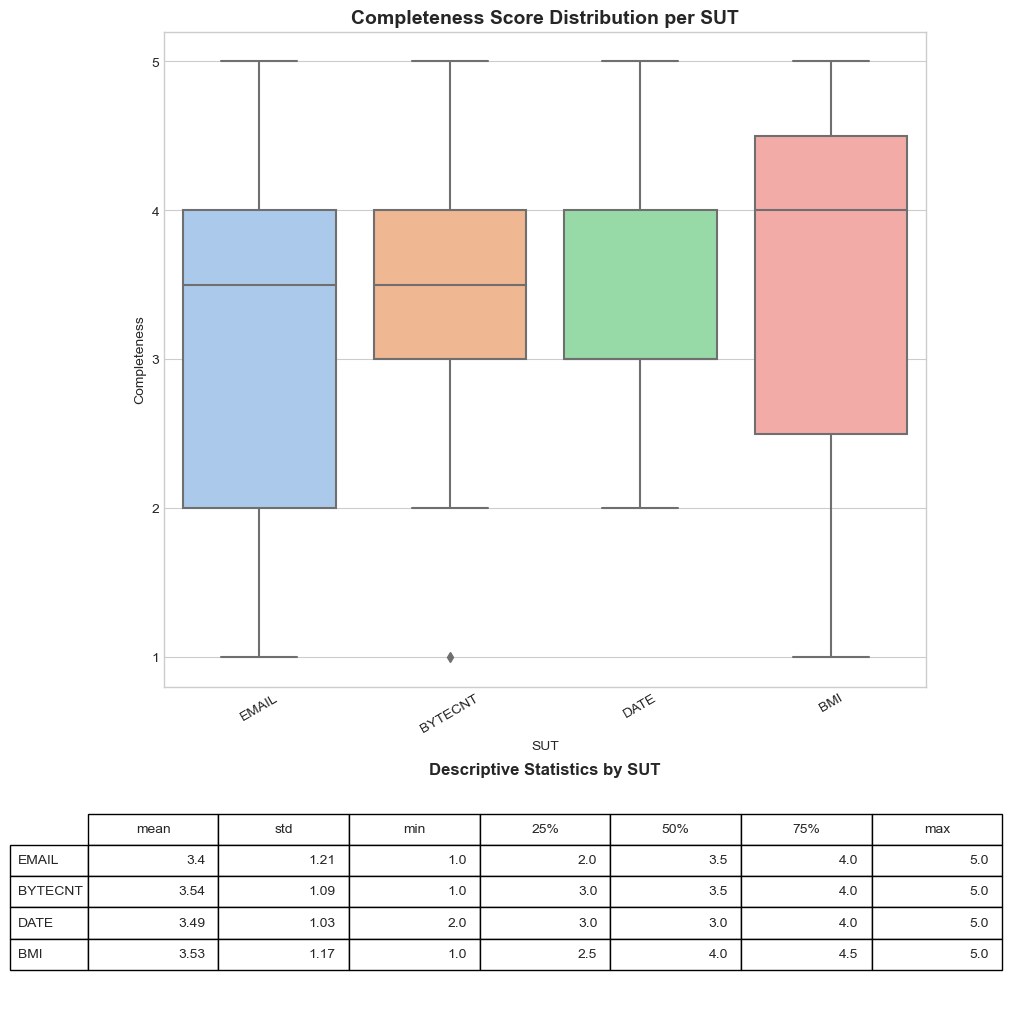

In [66]:
plot_box_and_table_per_category(DF, "completeness")

## *How does --Usefulness-- vary across all SUTs?*

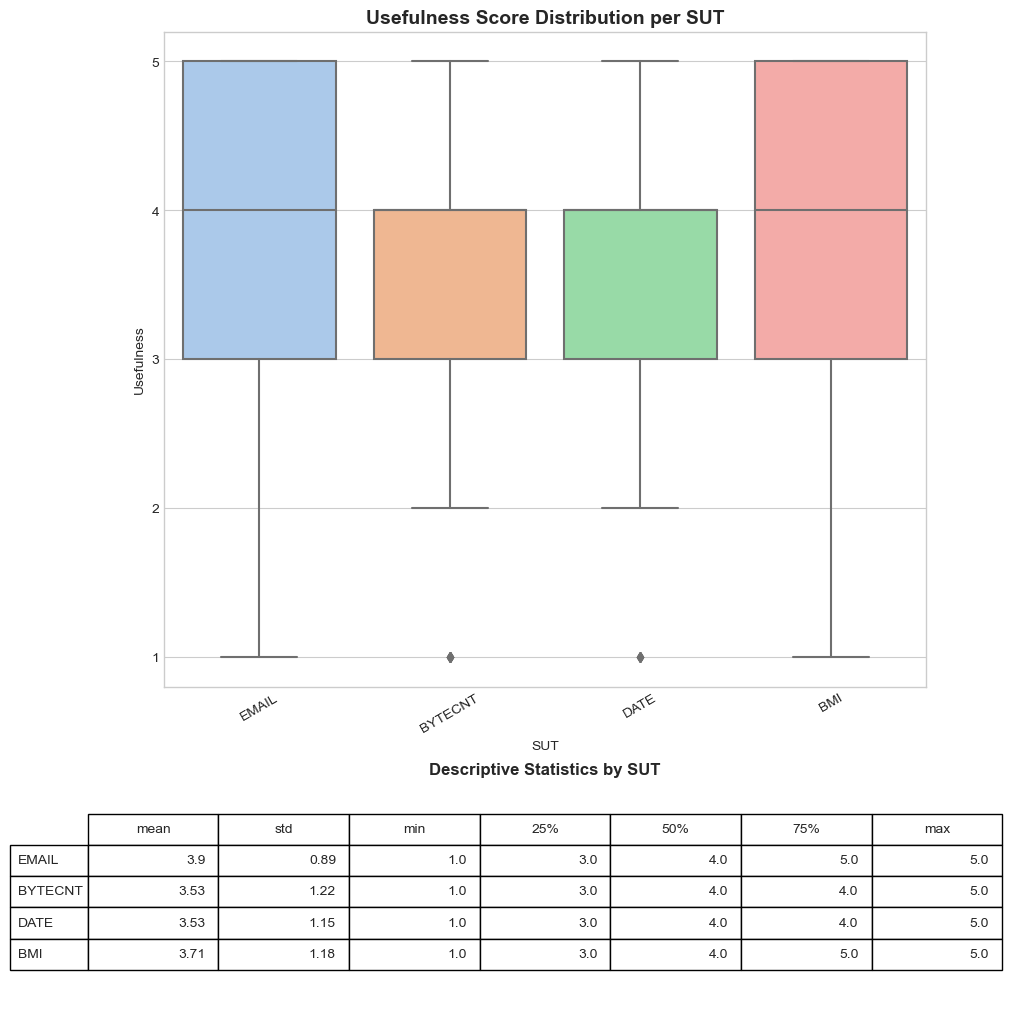

In [67]:
plot_box_and_table_per_category(DF, "usefulness")

# Descriptive Statistics: Per SUT

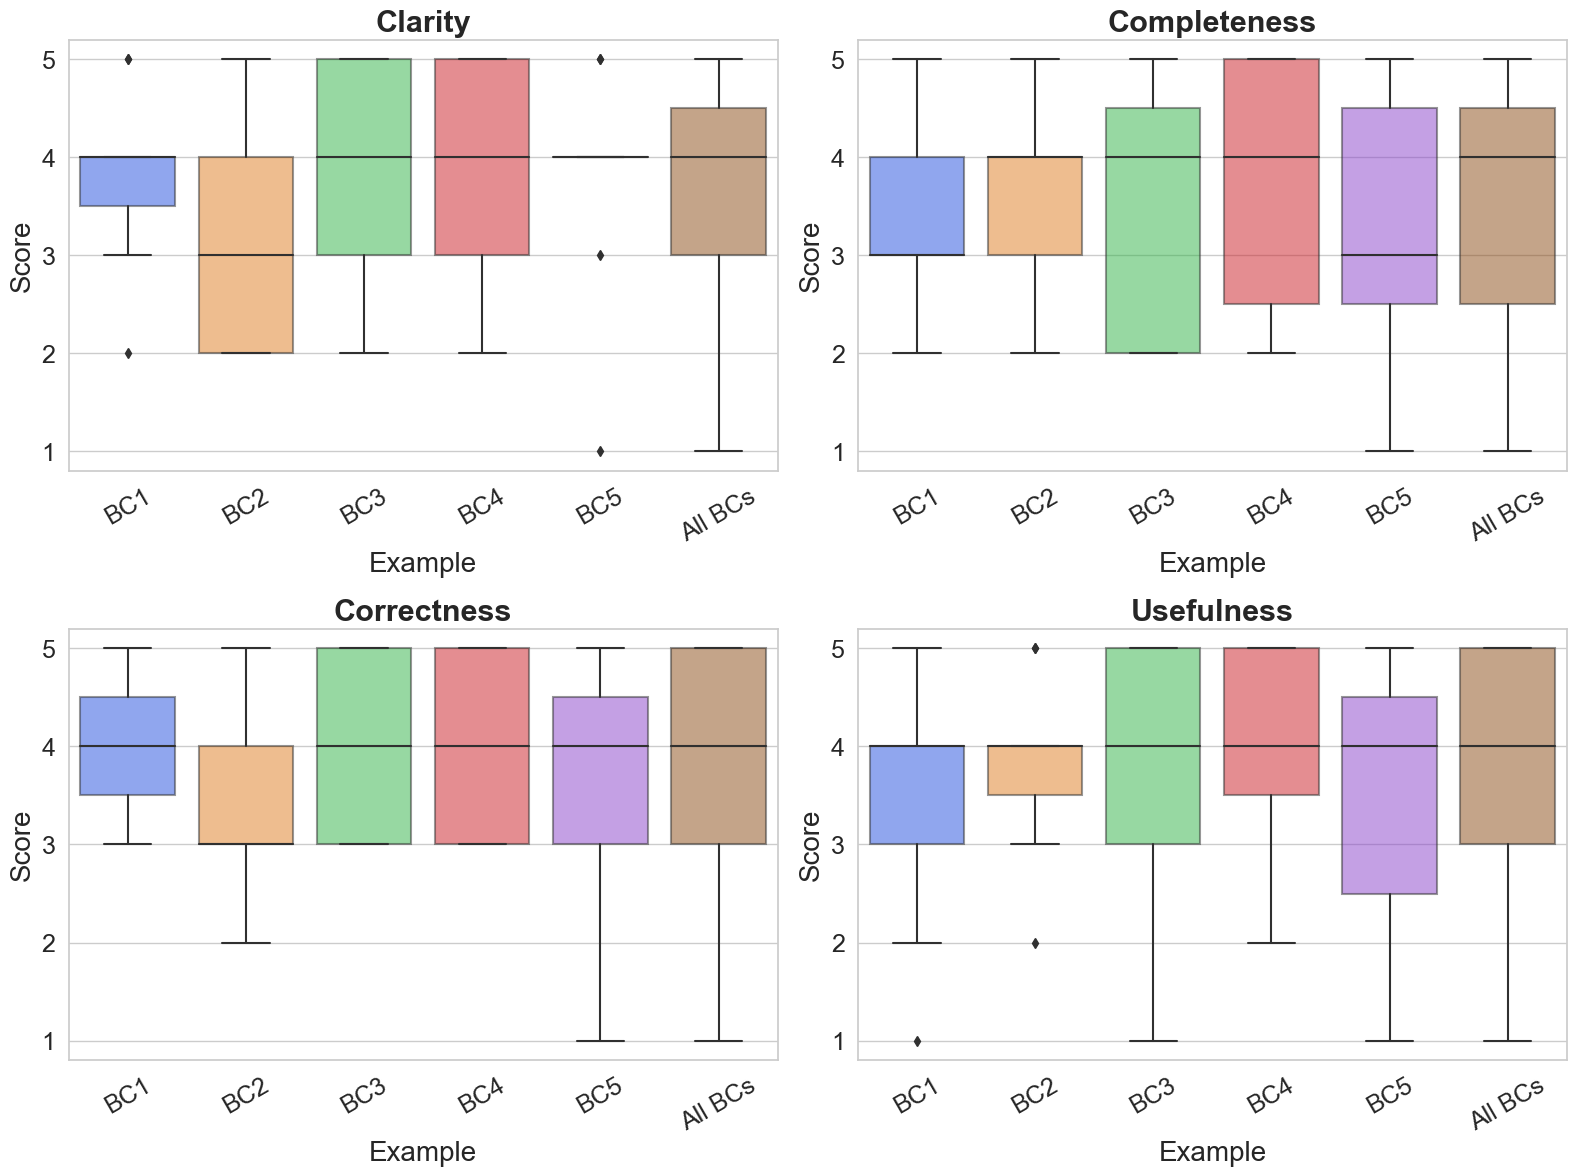

In [87]:
plot_box_per_sut(DF, 'bmi')

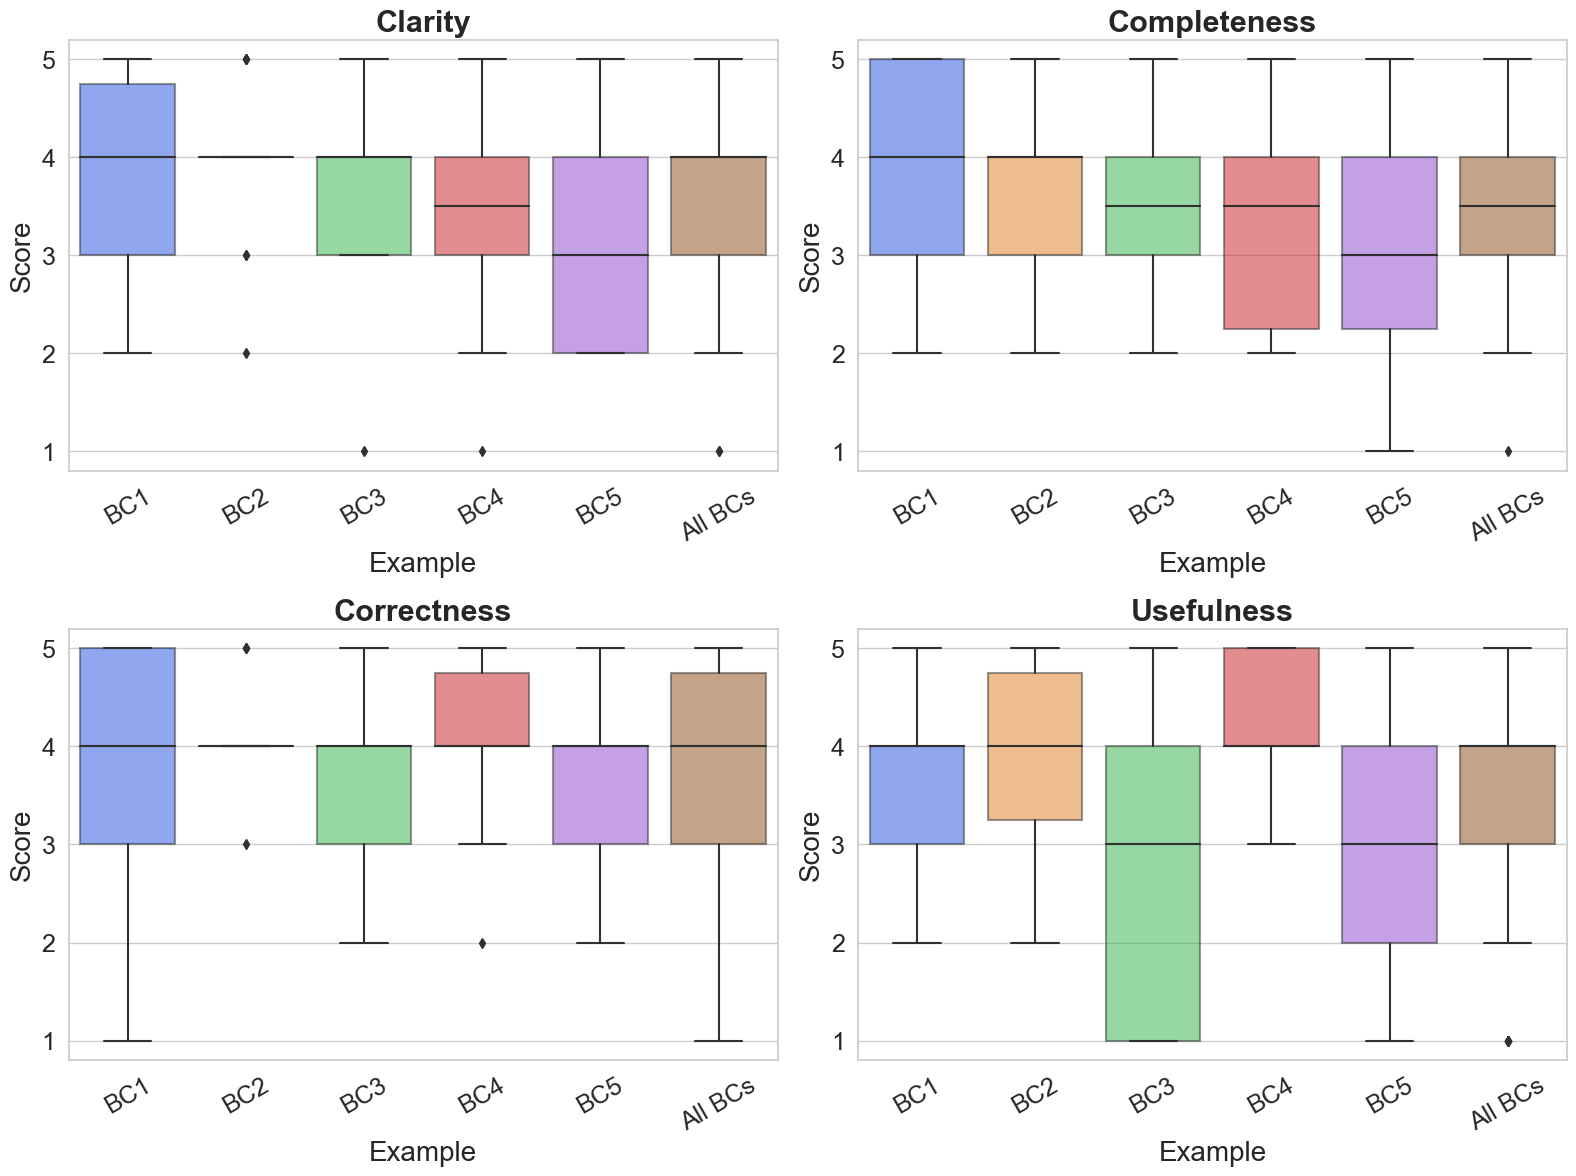

In [88]:
plot_box_per_sut(DF, 'bytecnt')

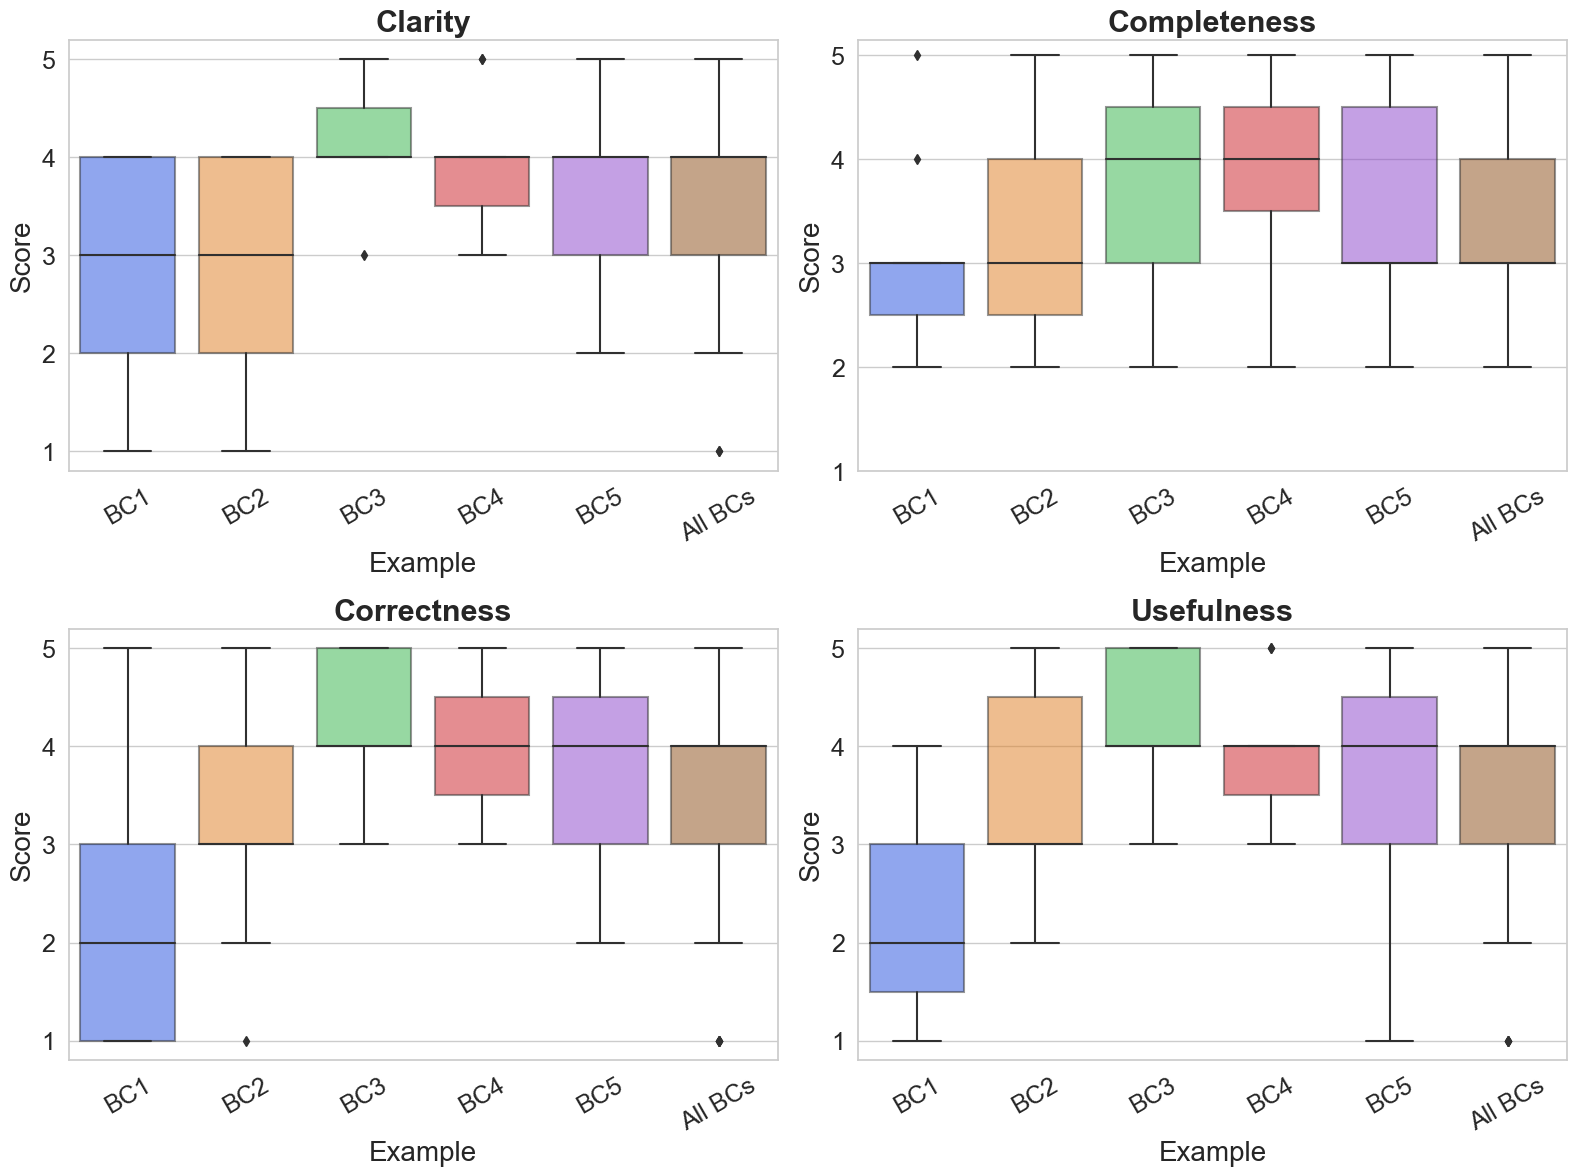

In [89]:
plot_box_per_sut(DF, 'date')

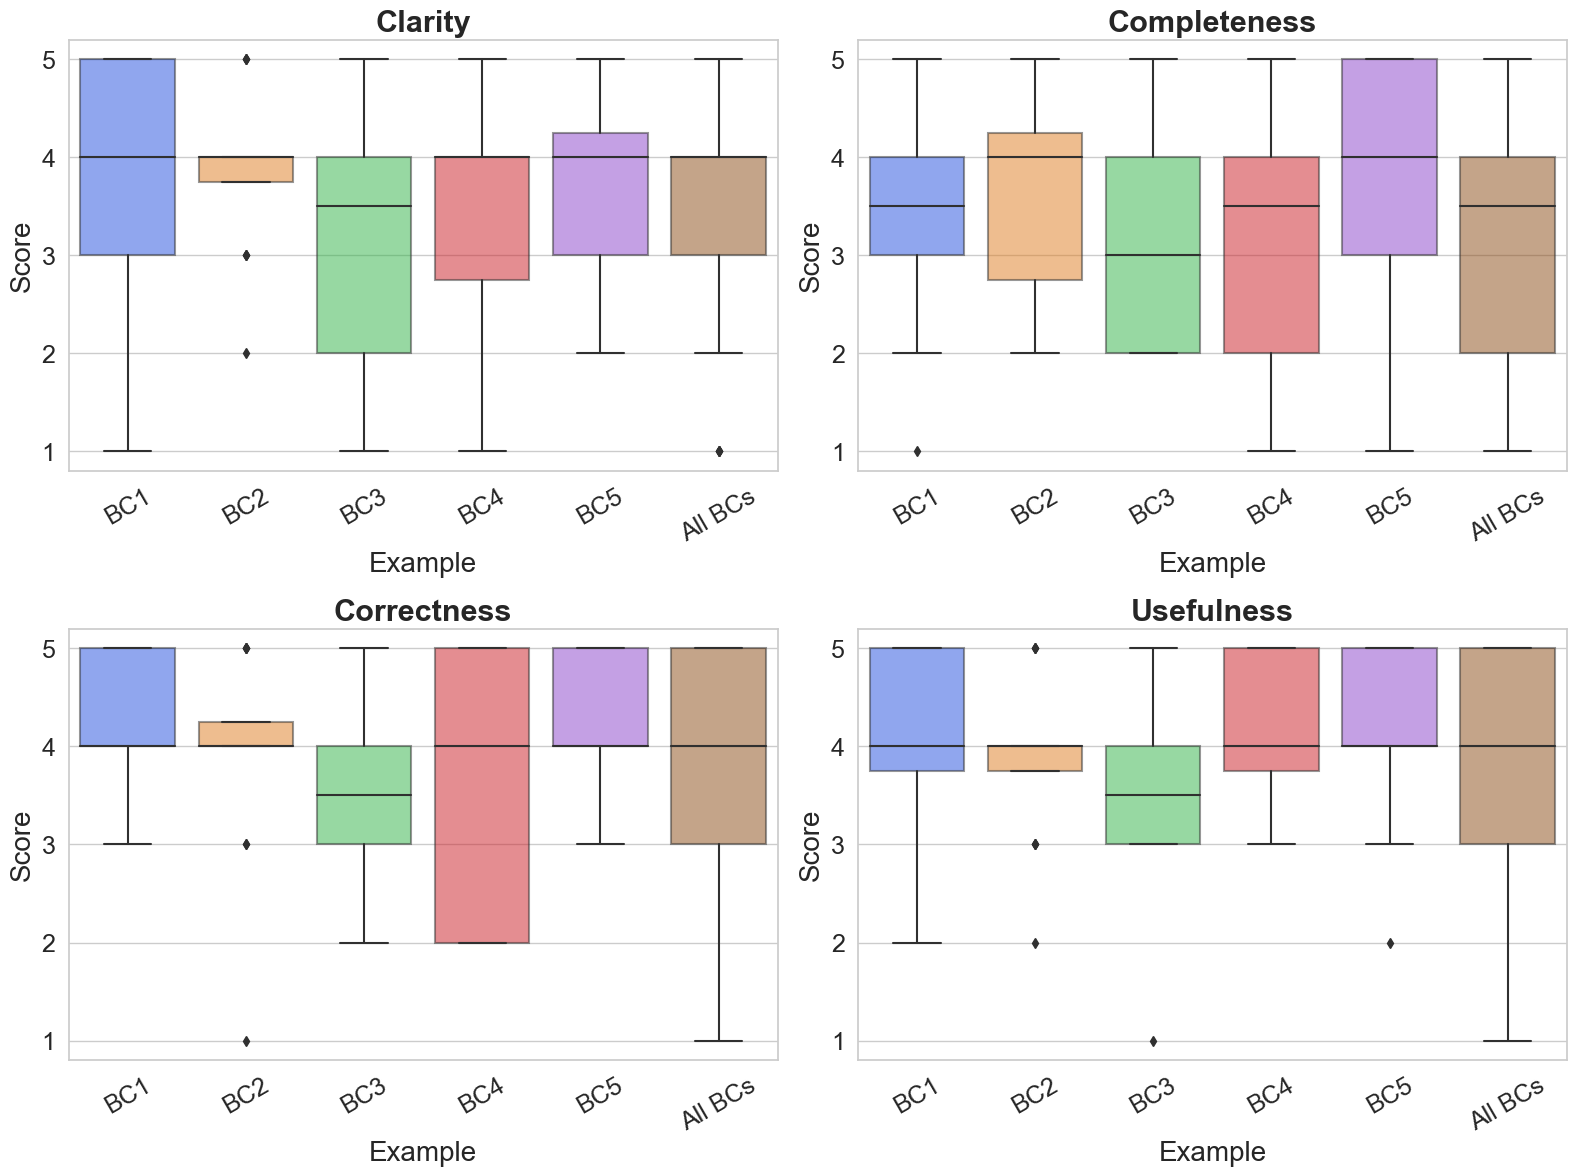

In [90]:
plot_box_per_sut(DF, 'email')